# CIFAR-10: Numerical Analysis

Let us briefly review the framework of flow matching. In flow matching, we aim to learn a velocity field $u_t(x)$ that transports samples from a noise distribution to the data distribution. A central phenomenon in this process is **velocity field collapse**: at a certain critical time $t_C$, the marginal velocity field becomes dominated by a single training example, effectively making it singular.

**Key question:** When does this collapse happen?

The timing of the collapse is determined by a fundamental parameter:
$$
\alpha = \frac{\log n}{d}
$$
where $n$ is the number of training samples and $d$ is the data dimension. For CIFAR-10, $n = 50,\!000$ and $d = 3 \times 32 \times 32 = 3072$, yielding $\alpha \approx 0.0035$.

**Note:** For computational efficiency, we use $n = 1000$ samples for most experiments instead of the full $n = 50,\!000$. This brings $\alpha$ to approximately $0.00225$, although the observed collapse times remain very similar.

**This notebook investigates:**

1. The **empirical entropy** of the softmax weights, to observe when collapse occurs in practice
2. **Isotropic models** for computing $t_C$ analytically, under the assumption of uniform variance
3. **Non-isotropic models** making use of the full eigenvalue spectrum of the data covariance
4. The **discrepancy** between theoretical predictions and empirical observations
5. **Effective dimension corrections** to reconcile theory and experiment

Additionally, we explore the [relationship between the marginal velocity field and the position field](#marginal-velocity-field-and-position-field).

In [1]:
# =============================================================================
# Import libraries
# =============================================================================
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.special import softmax
from pathlib import Path
from scipy.optimize import minimize_scalar

In [2]:
# =============================================================================
# CIFAR-10 Default Parameters
# =============================================================================
CIFAR10_D = 3072  # Dimension (3 * 32 * 32)
CIFAR10_N = 50000  # Number of training samples
CIFAR10_SIGMA2 = 0.24  # Per-coordinate variance after normalization
CIFAR10_ALPHA = np.log(CIFAR10_N) / CIFAR10_D  # ~0.0035

In [3]:
def load_cifar10_data_numpy(n_samples: int | None = 1000) -> np.ndarray:
    """
    Load CIFAR-10 training data with standard normalization.
    
    Parameters
    ----------
    n_samples : int
        Number of samples to load (use smaller for faster computation)
        
    Returns
    -------
    np.ndarray
        Data array of shape (n_samples, 3072)
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    dataset = datasets.CIFAR10(
        root="./data", 
        train=True, 
        download=True, 
        transform=transform
    )
    
    # Stack selected samples into array
    if n_samples is None:
        data = torch.stack([dataset[i][0].view(-1) for i in range(len(dataset))], dim=0).numpy()
    else:
        indices = np.random.choice(len(dataset), size=min(n_samples, len(dataset)), replace=False)
        data = torch.stack([dataset[i][0].view(-1) for i in indices], dim=0).numpy()

    return data

## Entropy of the Softmax Weights

The marginal velocity field can be written as a weighted sum over training points:
$$u_t(x) = \sum_{i=1}^{n} \lambda_i(x, t) \frac{x^{(i)} - x}{1 - t}$$

where the **softmax weights** are defined as:
$$\lambda_i(x, t) = \frac{\exp\left(-\frac{\|x - t x^{(i)}\|^2}{2(1-t)^2}\right)}{\sum_{j=1}^{n} \exp\left(-\frac{\|x - t x^{(j)}\|^2}{2(1-t)^2}\right)}$$

To measure the "spread" of these weights, we compute the **Shannon entropy**:
$$H(\lambda) = -\sum_{i=1}^{n} \lambda_i \log \lambda_i$$

**Expected behavior:**

- **At $t \approx 0$:** All weights are approximately equal ($\lambda_i \approx 1/n$), so $H \approx \log(n)$ (maximum entropy)
- **At $t \approx t_C$:** One weight dominates ($\lambda_i \approx 1$ for some $i$), so $H \approx 0$ (minimum entropy)

The entropy drop marks the **collapse transition** where the velocity field becomes dominated by a single training point.

In [4]:
def compute_lambda_weights(x_t: np.ndarray, data: np.ndarray, t: float) -> np.ndarray:
    """
    Compute the softmax weights lambda_i(x_t, t).
    
    lambda_i(x, t) = softmax(-||x - t*x^(i)||^2 / (2*(1-t)^2))
    
    Parameters
    ----------
    x_t : np.ndarray
        Current position, shape (d,) or (batch, d)
    data : np.ndarray
        Training data, shape (n, d)
    t : float
        Time in [0, 1)
        
    Returns
    -------
    np.ndarray
        Softmax weights, shape (n,) or (batch, n)
    """
    if t >= 1.0:
        raise ValueError("t must be < 1")
    if t == 0:
        # At t=0, all weights should be equal
        n = data.shape[0]
        if x_t.ndim == 1:
            return np.ones(n) / n
        else:
            return np.ones((x_t.shape[0], n)) / n
    
    # Compute scaled means
    scaled_data = t * data  # (n, d)
    
    # Handle batch dimension
    if x_t.ndim == 1:
        x_t = x_t[np.newaxis, :]  # (1, d)
        squeeze = True
    else:
        squeeze = False
    
    # Compute squared distances: ||x_t - t*x^(i)||^2
    # x_t: (batch, d), scaled_data: (n, d)
    diff = x_t[:, np.newaxis, :] - scaled_data[np.newaxis, :, :]  # (batch, n, d)
    sq_distances = np.sum(diff**2, axis=2)  # (batch, n)
    
    # Compute log weights (negative energies)
    log_weights = -sq_distances / (2 * (1 - t)**2)
    
    # Apply softmax along the n dimension
    weights = softmax(log_weights, axis=1)
    
    if squeeze:
        return weights[0]
    return weights


def compute_entropy(weights: np.ndarray) -> float:
    """
    Compute the entropy of a probability distribution.
    
    H = -sum_i p_i * log(p_i)
    
    Parameters
    ----------
    weights : np.ndarray
        Probability weights (should sum to 1)
        
    Returns
    -------
    float
        Entropy value
    """
    # Avoid log(0) by filtering out zero weights
    mask = weights > 1e-300
    if not np.any(mask):
        return 0.0
    p = weights[mask]
    return -np.sum(p * np.log(p))


def compute_entropy_vs_time(
    data: np.ndarray, 
    n_samples: int, 
    t_values: np.ndarray,
    seed: int | None = None,
    ) -> np.ndarray:
    """
    Compute the average entropy of lambda_i(x_t, t) over time.
    
    For each t, draw samples x_t = (1-t)*x_0 + t*x_1 where:
    - x_0 ~ N(0, I_d)
    - x_1 is uniformly sampled from data
    
    Then compute average entropy of the softmax weights.
    
    Parameters
    ----------
    data : np.ndarray
        Training data, shape (n, d)
    n_samples : int
        Number of samples to average over
    t_values : np.ndarray
        Time values to evaluate
    seed : int, optional
        Random seed for reproducibility
        
    Returns
    -------
    np.ndarray
        Average entropy at each time value, shape (len(t_values),)
    """
    if seed is not None:
        np.random.seed(seed)
    
    n, d = data.shape
    entropies = np.zeros(len(t_values))
    
    for i, t in enumerate(t_values):
        if t >= 1.0:
            entropies[i] = 0.0
            continue
            
        entropy_samples = []
        
        for _ in range(n_samples):
            # Sample x_0 from N(0, I_d)
            x_0 = np.random.randn(d)
            
            # Sample x_1 uniformly from data
            idx = np.random.randint(n)
            x_1 = data[idx]
            
            # Compute x_t
            x_t = (1 - t) * x_0 + t * x_1
            
            # Compute weights
            weights = compute_lambda_weights(x_t, data, t)
            
            # Compute entropy
            entropy_samples.append(compute_entropy(weights))
        
        entropies[i] = np.mean(entropy_samples)
    
    return entropies

In [5]:
def plot_entropy_vs_time(
    data: np.ndarray, 
    n_samples: int = 100,
    t_values: np.ndarray | None = None,
    t_max: float = 0.9,
    seed: int | None = 42,
    figsize: tuple[float, float] = (10, 6),
) -> None:
    """
    Plot entropy of lambda_i(x_t, t) vs time.
    
    The entropy should be high (close to log(n)) for small t when weights
    are spread across many data points, then decrease rapidly around the
    collapse time as weights concentrate on a single point.
    
    Parameters
    ----------
    data : np.ndarray
        Training data, shape (n, d)
    n_samples : int
        Number of samples to average over at each time
    t_values : np.ndarray, optional
        Time values to evaluate. If None, uses linspace(0.01, t_max, 50)
    t_max : float
        Maximum time value (default 0.5)
    seed : int, optional
        Random seed for reproducibility
    figsize : tuple
        Figure size if creating new figure
    """
    if t_values is None:
        t_values = np.linspace(0.01, t_max, 50)
    
    # Compute entropy
    entropies = compute_entropy_vs_time(data, n_samples, t_values, seed=seed)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot entropy
    ax.plot(t_values, entropies, 'b-', linewidth=2, label='Average entropy')
    
    # Add reference lines
    n = data.shape[0]
    max_entropy = np.log(n)
    ax.axhline(y=max_entropy, color='gray', linestyle='--', alpha=0.5, 
               label=f'Max entropy = log(n) ≈ {max_entropy:.2f}')
    ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    
    ax.set_xlabel('Time t', fontsize=12)
    ax.set_ylabel('Entropy H(λ)', fontsize=12)
    ax.set_title('Entropy of Softmax Weights vs Time', fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, t_max])
    ax.set_ylim([0, max_entropy * 1.1])

    plt.savefig("output/cifar10_entropy_vs_time.png")
    plt.show()

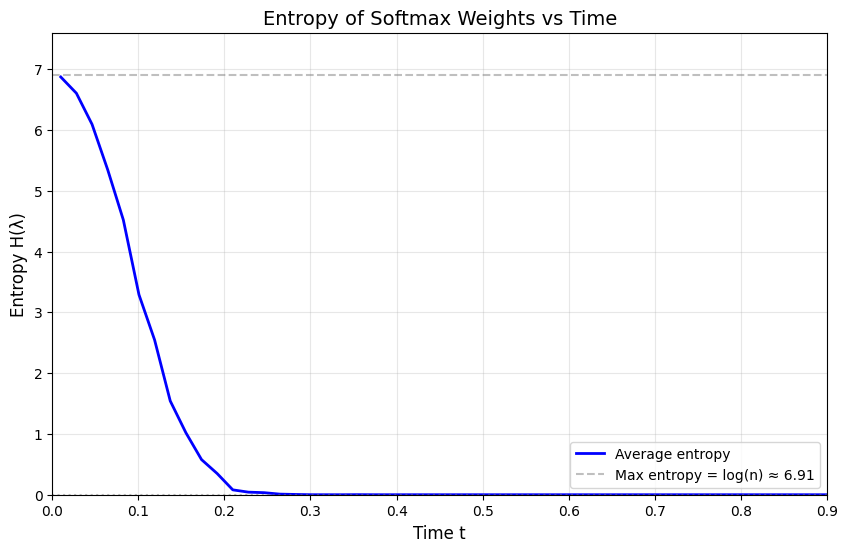

In [6]:
data = load_cifar10_data_numpy(1000)
plot_entropy_vs_time(data)

**Observations:**

The entropy drops sharply between $t \approx 0.1$ and $t \approx 0.3$. This indicates that:

- The softmax weights transition from being spread across many training points to concentrating on a single point
- The **empirical collapse time** lies in the range $t_C^{\text{empirical}} \in [0.1, 0.3]$

The theoretical collapse times we compute in the following sections should match this empirically observed transition.

## Collapse Time in the Isotropic Case

In the **isotropic case**, we assume the data covariance is a scalar multiple of the identity matrix: $C = \sigma^2 I_d$. For CIFAR-10, the per-coordinate variance is $\sigma^2 \approx 0.24$.

### Key quantities

The **time-dependent energy scale** is:
$$c(t) = \frac{1}{2}\left(1 + 2\sigma^2 \frac{t^2}{(1-t)^2}\right)$$

This controls the variance of the bulk energy distribution.

### Two methods for computing $t_C$

**1. Simple heuristic formula:**
Based on comparing typical bulk energy to planted energy:
$$t_C^{\text{heuristic}} \approx \frac{\sqrt{\alpha/\sigma^2}}{1 + \sqrt{\alpha/\sigma^2}}$$

**2. Full REM/LDP framework:**
The collapse criterion uses the rate function $I(\varepsilon)$ for the chi-squared distribution:
$$\alpha = I(\varepsilon_g) = \frac{1}{2}\left(\log(2c(t_C)) + \frac{1}{2c(t_C)} - 1\right)$$
where $\varepsilon_g = 1/2$ is the planted energy density.

In [7]:
def compute_c(t: float, sigma2: float) -> float:
    """
    Compute the time-dependent energy scale c(t).
    
    c(t) = (1/2) * (1 + 2*sigma^2 * t^2 / (1-t)^2)
    
    Parameters
    ----------
    t : float
        Time in [0, 1)
    sigma2 : float
        Per-coordinate variance of the data
        
    Returns
    -------
    float
        The energy scale c(t)
    """
    return 0.5 * (1 + 2 * sigma2 * t**2 / (1 - t)**2)


def compute_collapse_time_simple_isotropic(alpha: float, sigma2: float) -> float:
    """
    Compute the collapse time using the simple heuristic formula.
    
    This is based on comparing typical bulk energy to planted energy:
    
    t_C^{heuristic} ≈ sqrt(alpha/sigma^2) / (1 + sqrt(alpha/sigma^2))
    
    Parameters
    ----------
    alpha : float
        The dimensionless ratio log(n)/d
    sigma2 : float
        Per-coordinate variance of the data
        
    Returns
    -------
    float
        The predicted collapse time
    """
    ratio = np.sqrt(alpha / sigma2)
    return ratio / (1 + ratio)


def compute_collapse_time_rem_isotropic(alpha: float, sigma2: float, tol: float = 1e-10) -> float:
    """
    Compute the collapse time using the REM/LDP framework (isotropic case).
    
    Solves the equation:
    alpha = (1/2) * (log(2*c(t_C)) + 1/(2*c(t_C)) - 1)
    
    where c(t) = (1/2) * (1 + 2*sigma^2 * t^2 / (1-t)^2)
    
    This is derived from setting eps_g = 1/2 in I(eps_g) = alpha,
    where I is the rate function for the chi-squared distribution.
    
    Parameters
    ----------
    alpha : float
        The dimensionless ratio log(n)/d
    sigma2 : float
        Per-coordinate variance of the data
    tol : float
        Tolerance for the root-finding algorithm
        
    Returns
    -------
    float
        The predicted collapse time
    """
    def equation(t):
        c = compute_c(t, sigma2)
        return 0.5 * (np.log(2 * c) + 1 / (2 * c) - 1) - alpha
    
    # Find root in (0, 1) using Brent's method
    # Start from a small value to avoid division by zero
    t_low = 1e-6
    t_high = 1 - 1e-6
    
    # Check if solution exists in range
    f_low = equation(t_low)
    f_high = equation(t_high)
    
    if f_low * f_high > 0:
        # If no sign change, check which boundary is closer
        if abs(f_low) < abs(f_high):
            return t_low
        else:
            return t_high
    
    return brentq(equation, t_low, t_high, xtol=tol)

In [8]:
def plot_alpha_c_vs_time(
    n_points: int = 500,
    t_max: float = 0.99,
    figsize: tuple = (10, 6),
) -> None:
    """
    Plot the critical entropy threshold α_c(c(t)) across time.
    
    Shows that for CIFAR-like α ≪ 1, we have α ≪ α_c(c(t)) for all t ∈ [0,1),
    meaning the system is always in the glass phase.
    
    The critical threshold is:
        α_c(c) = (1/2) * (log(1 + 2c) - 2c/(1 + 2c))
    
    where c(t) = (1/2) * (1 + 2σ² t² / (1-t)²)
    
    Parameters
    ----------
    sigma2 : float
        Per-coordinate variance of the data (default: CIFAR-10 value)
    alpha : float
        The dimensionless ratio log(n)/d (default: CIFAR-10 value)
    n_points : int
        Number of time points to plot
    t_max : float
        Maximum time value (should be < 1 to avoid singularity)
    figsize : tuple
        Figure size
    """
    # Time array
    t_values = np.linspace(0, t_max, n_points)
    
    # Compute c(t) for each time
    c_values = np.array([compute_c(t, CIFAR10_SIGMA2) for t in t_values])
    
    # Compute α_c(c(t)) using the formula:
    # α_c(c) = (1/2) * (log(1 + 2c) - 2c/(1 + 2c))
    def alpha_c(c):
        return 0.5 * (np.log(1 + 2*c) - 2*c / (1 + 2*c))
    
    alpha_c_values = alpha_c(c_values)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot α_c(c(t))
    ax.plot(t_values, alpha_c_values, 'b-', linewidth=2, 
            label=r'$\alpha_c(c(t))$ (glass/liquid threshold)')
    
    # Plot horizontal line at α
    ax.axhline(y=CIFAR10_ALPHA, color='r', linestyle='--', linewidth=2,
               label=fr'$\alpha = \log(n)/d \approx {CIFAR10_ALPHA:.4f}$ (CIFAR-10)')
    
    # Formatting
    ax.set_xlabel(r'Time $t$', fontsize=12)
    ax.set_ylabel(r'$\alpha$', fontsize=12)
    ax.set_title(r'CIFAR-10 is Always in the Glass Phase: $\alpha \ll \alpha_c(c(t))$ for all $t$', fontsize=14)
    ax.set_xlim(0, t_max)
    ax.set_ylim(0, max(alpha_c_values) * 1.1)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add annotation showing the minimum gap
    min_alpha_c = np.min(alpha_c_values)
    min_idx = np.argmin(alpha_c_values)
    t_at_min = t_values[min_idx]
    ax.annotate(
        fr'min $\alpha_c \approx {min_alpha_c:.4f}$' + '\n' + fr'at $t=0$',
        xy=(t_at_min, min_alpha_c),
        xytext=(0.15, min_alpha_c + 0.02),
        fontsize=10,
        arrowprops=dict(arrowstyle='->', color='black', lw=1)
    )
    
    plt.tight_layout()
    plt.savefig("output/cifar10_alpha_c_vs_time.png")
    plt.show()

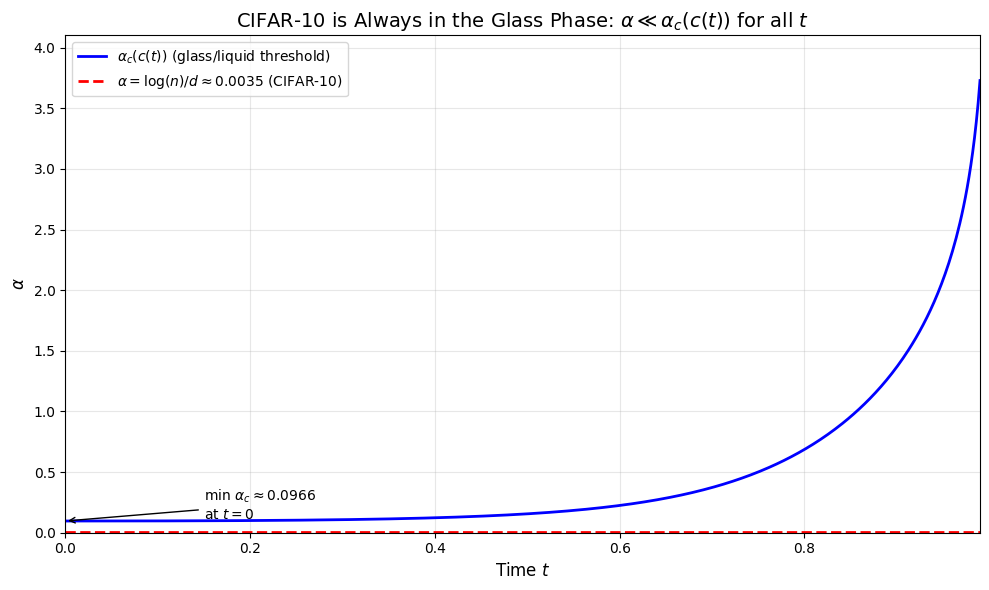

In [9]:
plot_alpha_c_vs_time()

**Observations:**

- For CIFAR-10, we have $\alpha \ll \alpha_c(c(t))$ for all $t \in [0, 1)$
- This means the system is always in the **glass phase**

**What is the glass phase?**

The Random Energy Model (REM) framework distinguishes two phases:

- **Liquid phase** ($\alpha > \alpha_c$): Many bulk states have energies comparable to the planted state. The partition function is dominated by an extensive number of configurations.
- **Glass phase** ($\alpha < \alpha_c$): The planted state has much lower energy than typical bulk states. Only one (or very few) configurations contribute to the partition function.

For CIFAR-10, we are deep in the glass phase, which simplifies the collapse time computation. The critical threshold is:
$$\alpha_c(c) = \frac{1}{2}\left(\log(1 + 2c) - \frac{2c}{1 + 2c}\right)$$

In [10]:
t_c_simple_isotropic = compute_collapse_time_simple_isotropic(CIFAR10_ALPHA, CIFAR10_SIGMA2)
t_c_rem_isotropic = compute_collapse_time_rem_isotropic(CIFAR10_ALPHA, CIFAR10_SIGMA2)

print(f"Collapse time (simple isotropic): {t_c_simple_isotropic:.6f}")
print(f"Collapse time (REM/LDP isotropic): {t_c_rem_isotropic:.6f}")

Collapse time (simple isotropic): 0.108052
Collapse time (REM/LDP isotropic): 0.341177


Now, let us extend this to the non-isotropic case.

## Eigenvalues of the Data Covariance Matrix

To extend the analysis to the **non-isotropic case**, we need the eigenvalues $\{\mu_k\}_{k=1}^d$ of the empirical covariance matrix $C$ of the CIFAR-10 data.

**Why eigenvalues matter:**

- In the isotropic model, all eigenvalues are equal: $\mu_k = \sigma^2$
- Real image data has a **spiked spectrum**: a few large eigenvalues capture most of the variance
- This changes the energy landscape and affects the collapse time prediction

**What we expect for CIFAR-10:**

- Natural images are highly structured, so the covariance is far from isotropic
- Most variance should be captured by the top few principal components
- This leads to an **effective dimension** $d_{\text{eff}} \ll d$

In [11]:
cifar10_cov_eigs_path = "output/cifar10_cov_eigs.txt"

def compute_eigenvalues() -> np.ndarray:
    # 1. Load CIFAR-10 with normalization
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

    n = len(dataset)
    d = 3 * 32 * 32

    # 2. Stack all images into [n, d]
    X = torch.stack([dataset[i][0].view(-1) for i in range(n)], dim=0)  # shape [n, 3072]

    # 3. Empirical mean
    mu = X.mean(dim=0)  # [d]

    # 4. Center
    Xc = X - mu  # [n, d]

    # 5. Empirical covariance (3072 x 3072)
    C0 = (Xc.T @ Xc) / n  # [d, d]

    # 6. Largest eigenvalue
    # For d=3072 you can do full eig, or use symeig for symmetric matrices
    eigs = torch.linalg.eigvalsh(C0).numpy()  # sorted eigenvalues

    # 7. Save eigenvalues
    np.savetxt(cifar10_cov_eigs_path, eigs)

    return eigs

if Path(cifar10_cov_eigs_path).exists():    
    eigs = np.loadtxt(cifar10_cov_eigs_path)
else:
    eigs = compute_eigenvalues()

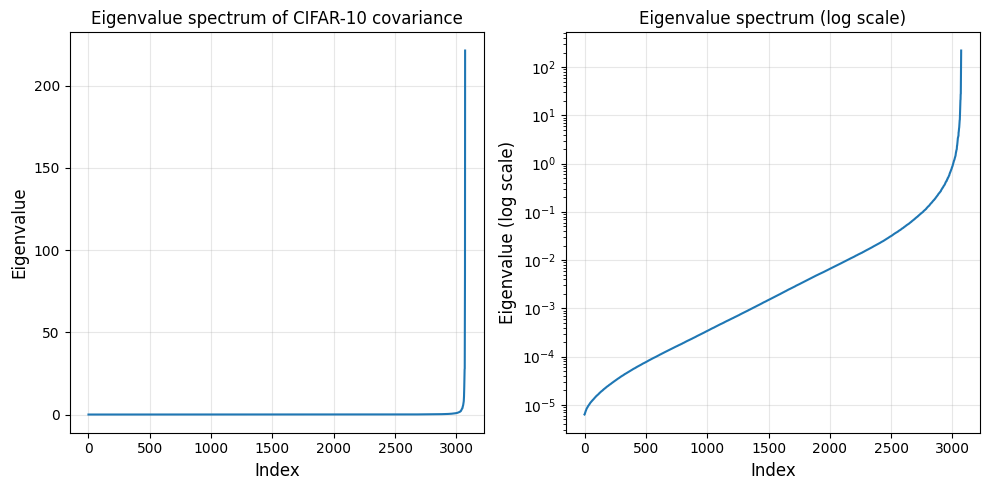

In [12]:
# Plot eigenvalue spectrum of CIFAR-10 covariance matrix
plt.figure(figsize=(10, 5))

# Subplot 1: All eigenvalues
plt.subplot(1, 2, 1)
plt.plot(eigs, linewidth=1.5)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Eigenvalue', fontsize=12)
plt.title('Eigenvalue spectrum of CIFAR-10 covariance', fontsize=12)
plt.grid(True, alpha=0.3)

# Subplot 2: Log scale to see the full range
plt.subplot(1, 2, 2)
plt.semilogy(eigs, linewidth=1.5)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Eigenvalue (log scale)', fontsize=12)
plt.title('Eigenvalue spectrum (log scale)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("output/cifar10_eigenvalues.png")
plt.show()


**Observations:**

The empirical covariance matrix of CIFAR-10 has a highly **spiked spectrum**:

| Statistic | Value |
|-----------|-------|
| Mean eigenvalue $\bar{\mu}$ | $\approx 0.248$ |
| Eigenvalue range | $[6.3 \times 10^{-6}, 221]$ |
| Ratio $\mu_{\max}/\bar{\mu}$ | $\approx 893\times$ |

**Effective dimension at different variance thresholds:**

| Variance Captured | $d_{\text{eff}}$ | Fraction of $d$ |
|-------------------|------------------|-----------------|
| 90% | 99 | 3.2% |
| 95% | 217 | 7.1% |
| 99% | 658 | 21.4% |

**Key insight:** The mean eigenvalue $\bar{\mu} \approx 0.248$ is very close to the isotropic $\sigma^2 = 0.24$, but the eigenvalue spectrum spans **8 orders of magnitude**. This extreme heterogeneity will significantly affect the non-isotropic collapse time prediction.

## Collapse Time in the Non-Isotropic Case

When the data covariance $C$ has eigenvalues $\{\mu_k\}$ that are not all equal, we use the **Gärtner-Ellis theorem** (a generalization of large deviation principles) to compute the collapse time.

### Time-dependent effective eigenvalues

At time $t$, the effective covariance of the bulk energy distribution has eigenvalues:
$$\lambda_k^{(t)} = 1 + \frac{2t^2}{(1-t)^2} \mu_k$$

### Scaled log-moment generating function

$$\Lambda_t(\theta) = \frac{1}{d}\sum_{k=1}^{d} \left(-\frac{1}{2}\log(1 - \theta\lambda_k^{(t)})\right)$$

This is well-defined only for $\theta < 1/\lambda_{\max}^{(t)}$, which becomes increasingly restrictive as $t$ increases.

### Rate function via Legendre transform

$$I_t(\varepsilon) = \sup_{\theta < 1/\lambda_{\max}^{(t)}} \left(\theta\varepsilon - \Lambda_t(\theta)\right)$$

### Collapse criterion

The collapse occurs when the bulk quenched free energy satisfies:
$$\Phi(1, t_C) = \sup_{\varepsilon} \left(\alpha - I_{t_C}(\varepsilon) - \varepsilon\right) = -\frac{1}{2}$$

In [13]:
def compute_effective_eigenvalues(t: float, eigenvalues: np.ndarray) -> np.ndarray:
    """
    Compute effective eigenvalues of the covariance at time t.
    
    lambda_k^(t) = 1 + 2*t^2/(1-t)^2 * mu_k
    
    Parameters
    ----------
    t : float
        Time in [0, 1)
    eigenvalues : np.ndarray
        Eigenvalues of the data covariance matrix
        
    Returns
    -------
    np.ndarray
        Effective eigenvalues at time t
    """
    factor = 2 * t**2 / (1 - t)**2
    return 1 + factor * eigenvalues


def compute_scaled_log_mgf(theta: float, effective_eigs: np.ndarray) -> float:
    """
    Compute the scaled log moment generating function (Gärtner-Ellis).
    
    Lambda_t(theta) = (1/d) * sum_k (-0.5 * log(1 - theta * lambda_k^(t)))
    
    Parameters
    ----------
    theta : float
        The parameter theta (must be < 1/lambda_max)
    effective_eigs : np.ndarray
        Effective eigenvalues at time t
        
    Returns
    -------
    float
        The scaled log-MGF value
    """
    d = len(effective_eigs)
    # Check validity
    if theta >= 1 / effective_eigs.max():
        return np.inf
    
    log_terms = -0.5 * np.log(1 - theta * effective_eigs)
    return np.sum(log_terms) / d


def compute_rate_function_empirical(eps: float, effective_eigs: np.ndarray) -> float:
    """
    Compute the rate function I_t(eps) via numerical Legendre transform.
    
    I_t(eps) = sup_{theta < 1/lambda_max} (theta * eps - Lambda_t(theta))
    
    Parameters
    ----------
    eps : float
        Energy density
    effective_eigs : np.ndarray
        Effective eigenvalues at time t
        
    Returns
    -------
    float
        The rate function value
    """
    lambda_max = effective_eigs.max()
    theta_max = 1 / lambda_max - 1e-10
    
    # Objective to maximize: theta * eps - Lambda_t(theta)
    def neg_objective(theta):
        if theta >= theta_max or theta <= -10:  # bound from below too
            return np.inf
        return -(theta * eps - compute_scaled_log_mgf(theta, effective_eigs))
    
    result = minimize_scalar(neg_objective, bounds=(-5, theta_max - 1e-10), method='bounded')
    return -result.fun


def compute_bulk_free_energy(alpha: float, effective_eigs: np.ndarray) -> float:
    """
    Compute the bulk quenched free energy Phi(1, t).
    
    Phi(1, t) = sup_eps (alpha - I_t(eps) - eps)
    
    Parameters
    ----------
    alpha : float
        The dimensionless ratio log(n)/d
    effective_eigs : np.ndarray
        Effective eigenvalues at time t
        
    Returns
    -------
    float
        The bulk free energy
    """
    def neg_objective(eps):
        if eps <= 0:
            return np.inf
        I_eps = compute_rate_function_empirical(eps, effective_eigs)
        return -(alpha - I_eps - eps)
    
    # Search over reasonable range of eps
    result = minimize_scalar(neg_objective, bounds=(0.01, 5.0), method='bounded')
    return -result.fun


def compute_collapse_time_rem_non_isotropic(alpha: float, eigenvalues: np.ndarray, tol: float = 1e-4) -> float:
    """
    Compute the collapse time using empirical eigenvalues (non-isotropic case).
    
    Uses the Gärtner-Ellis theorem with the empirical spectral distribution.
    Finds t such that Phi(1, t) = -1/2 (collapse criterion).
    
    WARNING: This function may give unrealistic results for highly non-isotropic
    spectra because it assumes Gaussian data. Use compute_collapse_time_corrected()
    for bounded image data.
    
    Parameters
    ----------
    alpha : float
        The dimensionless ratio log(n)/d
    eigenvalues : np.ndarray
        Eigenvalues of the data covariance matrix
    tol : float
        Tolerance for the root-finding algorithm
        
    Returns
    -------
    float
        The predicted collapse time
    """
    def collapse_criterion(t):
        effective_eigs = compute_effective_eigenvalues(t, eigenvalues)
        phi = compute_bulk_free_energy(alpha, effective_eigs)
        return phi + 0.5  # Looking for phi = -0.5
    
    # Find root in (0, 1)
    t_low = 0.01
    t_high = 0.99
    
    # Check if solution exists
    f_low = collapse_criterion(t_low)
    f_high = collapse_criterion(t_high)
    
    if f_low * f_high > 0:
        # No sign change - return boundary
        if abs(f_low) < abs(f_high):
            return t_low
        return t_high
    
    return brentq(collapse_criterion, t_low, t_high, xtol=tol)

In [14]:
# Collapse time in the non-isotropic case

t_c_rem_non_isotropic = compute_collapse_time_rem_non_isotropic(CIFAR10_ALPHA, eigs)
print(f"Collapse time (REM/LDP non-isotropic): {t_c_rem_non_isotropic:.6f}")

Collapse time (REM/LDP non-isotropic): 0.797510


## The Discrepancy: Theory vs Observation

When computing the collapse time $t_C$ for CIFAR-10 using different methods, we observe a striking discrepancy:

| Method | Collapse Time $t_C$ |
|--------|---------------------|
| Simple heuristic (isotropic) | 0.108 |
| Full REM/LDP (isotropic, $\sigma^2 = 0.24$) | 0.341 |
| **Empirical eigenvalues (non-isotropic)** | **0.798** |
| **Actual entropy drop (empirical)** | **~0.1 - 0.3** |

The non-isotropic model with empirical eigenvalues predicts collapse much later than both the isotropic models and the actual observed entropy drop. Why?

**Contributing Factors**

| Factor | Effect | 
|--------|--------|
| Gaussian assumption violated | Theory assumes unbounded Gaussian data |
| Effective dimension reduction | Spiked spectrum leads to smaller effective $d$ |

### 1. The Gaussian Assumption is Violated

**The Problem:**

The REM/LDP theory assumes training data follows:
$$x^{(i)} \sim \mathcal{N}(0, C)$$

where $C$ is the covariance matrix with eigenvalues $\{\mu_k\}$. But real CIFAR-10 images:

- Are **bounded** in $[-1, 1]^d$ (after normalization)
- Have **complex correlations** beyond second-order statistics
- Cannot exploit high-variance directions as freely as Gaussians

**The Consequence:**

The large eigenvalues in the empirical spectrum (up to ~221) allow *theoretical* Gaussian samples to have extreme projections onto principal components. This makes bulk energies more variable in theory, allowing some bulk states to compete with the planted state longer. Real images don't have this flexibility—they're constrained, so the actual collapse happens earlier.

### 2. Effective Dimension Reduction

**The Problem:**

CIFAR-10's eigenvalue spectrum is highly **spiked**—most variance is captured by a small number of principal components.

| Variance Captured | Effective Dimension $d_{\text{eff}}$ |
|-------------------|--------------------------------------|
| 90% | **99** |
| 95% | **217** |
| 99% | **658** |

The entropy parameter in the theory is:
$$\alpha = \frac{\log n}{d}$$

But if the data effectively lives in $d_{\text{eff}} \ll d$ dimensions:
$$\alpha_{\text{eff}} = \frac{\log n}{d_{\text{eff}}} \gg \alpha$$

**Actual calculation:**

- Full dimension: $\alpha = \log(50000)/3072 \approx 0.0035$
- With $d_{\text{eff}} = 217$ (95%): $\alpha_{\text{eff}} = \log(50000)/217 \approx 0.050$

### The Solution: Effective Dimension Model

We can correct the prediction by using the **effective dimension** approach: apply the isotropic formula with $\alpha_{\text{eff}}$ and $\sigma^2_{\text{eff}}$ (the mean variance in the top $d_{\text{eff}}$ components).

In [15]:
def compute_effective_dimension_alpha_and_sigma2(n: int, eigenvalues: np.ndarray, variance_threshold: float = 0.95) -> tuple[int, float, float]:
    """
    Compute alpha and sigma2 using effective dimension model.
    
    Projects the problem onto the effective subspace where most variance lives,
    
    Parameters
    ----------
    n : int
        Number of training samples
    eigenvalues : np.ndarray
        Eigenvalues of the data covariance matrix
    variance_threshold : float
        Fraction of variance to capture (default 0.95)
        
    Returns
    -------
    tuple[int, float, float]
        d_eff, alpha_eff, sigma2_eff
    """
    # Sort eigenvalues in descending order
    sorted_eigs = np.sort(eigenvalues)[::-1]
    cumsum = np.cumsum(sorted_eigs)
    total = cumsum[-1]
    
    # Find effective dimension
    d_eff = np.searchsorted(cumsum / total, variance_threshold) + 1
    d_eff = min(d_eff, len(eigenvalues))
    
    # Compute effective α and σ²
    alpha_eff = np.log(n) / d_eff
    sigma2_eff = np.mean(sorted_eigs[:d_eff])  # Mean of top eigenvalues

    return d_eff, alpha_eff, sigma2_eff

In [16]:
def plot_alpha_c_vs_alpha_eff(
    n: int,
    eigenvalues: np.ndarray,
    variance_threshold: float = 0.95,
    n_points: int = 500,
    t_max: float = 0.99,
    figsize: tuple = (10, 6),
) -> None:
    """
    Plot α_c(c(t)) vs α_eff to check glass/liquid phase using effective dimension.
    
    Uses the effective dimension model to compute α_eff and σ²_eff, then plots
    the critical threshold α_c(c(t)) to visualize the phase.
    
    Glass phase: α_eff < α_c(c(t)) for all t
    Liquid phase: α_eff ≥ α_c(c(t)) for some t
    
    Parameters
    ----------
    n : int
        Number of training samples
    eigenvalues : np.ndarray
        Eigenvalues of the data covariance matrix
    variance_threshold : float
        Fraction of variance to capture for effective dimension (default 0.95)
    n_points : int
        Number of time points to plot
    t_max : float
        Maximum time value (should be < 1)
    figsize : tuple
        Figure size
    """
    # Compute effective dimension parameters
    d_eff, alpha_eff, sigma2_eff = compute_effective_dimension_alpha_and_sigma2(
        n, eigenvalues, variance_threshold
    )
    
    # Time array
    t_values = np.linspace(0, t_max, n_points)
    c_values = np.array([compute_c(t, sigma2_eff) for t in t_values])
    
    # Compute α_c(c) = (1/2) * (log(1 + 2c) - 2c/(1 + 2c))
    def alpha_c(c):
        return 0.5 * (np.log(1 + 2*c) - 2*c / (1 + 2*c))
    
    alpha_c_values = alpha_c(c_values)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot α_c(c(t))
    ax.plot(t_values, alpha_c_values, 'b-', linewidth=2, 
            label=r'$\alpha_c(c(t))$ (glass/liquid threshold)')
    
    # Plot horizontal line at α_eff
    ax.axhline(y=alpha_eff, color='r', linestyle='--', linewidth=2,
               label=fr'$\alpha_{{\mathrm{{eff}}}} = \log(n)/d_{{\mathrm{{eff}}}} \approx {alpha_eff:.4f}$')
    
    # Formatting
    ax.set_xlabel(r'Time $t$', fontsize=12)
    ax.set_ylabel(r'$\alpha$', fontsize=12)
    ax.set_title(
        fr'Phase Diagram (Effective Dim): $d_{{\mathrm{{eff}}}}={d_eff}$ ({variance_threshold*100:.0f}% var), '
        fr'$\sigma^2_{{\mathrm{{eff}}}}={sigma2_eff:.4f}$',
        fontsize=13
    )
    ax.set_xlim(0, t_max)
    
    # Set y-limits to show both alpha values nicely
    y_max = max(np.max(alpha_c_values), alpha_eff) * 1.15
    y_min = 0
    ax.set_ylim(y_min, y_max)
    
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add annotation for minimum α_c
    min_idx = np.argmin(alpha_c_values)
    t_at_min = t_values[min_idx]
    min_alpha_c = alpha_c_values[min_idx]
    ax.annotate(
        fr'min $\alpha_c \approx {min_alpha_c:.4f}$',
        xy=(t_at_min, min_alpha_c),
        xytext=(0.15, min_alpha_c + (y_max - y_min) * 0.1),
        fontsize=10,
        arrowprops=dict(arrowstyle='->', color='black', lw=1)
    )
    
    plt.tight_layout()
    plt.savefig("output/effective_dimension_phase_diagram.png")
    plt.show()

In [17]:
d_eff, alpha_eff, sigma2_eff = compute_effective_dimension_alpha_and_sigma2(CIFAR10_N, eigs)
print(f"Effective dimension: d_eff = {d_eff}, alpha_eff = {alpha_eff}, sigma2_eff = {sigma2_eff}")


Effective dimension: d_eff = 217, alpha_eff = 0.049860729421245545, sigma2_eff = 3.335034586935549


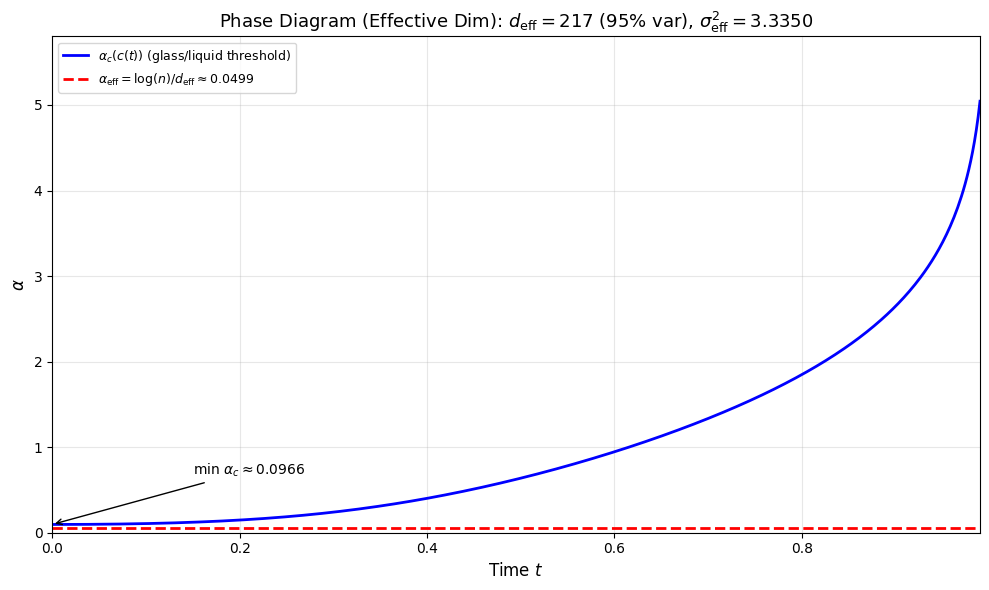

In [18]:
plot_alpha_c_vs_alpha_eff(CIFAR10_N, eigs)

**Observations:**

- The effective dimension is $d_{\text{eff}} = 217$ (at 95% variance), which is only **7%** of the full dimension $d = 3072$
- The effective parameters are: $\alpha_{\text{eff}} \approx 0.050$ and $\sigma^2_{\text{eff}} \approx 3.34$
- The system is still in the **glass phase** under the effective dimension model

**Why this approach works:**

1. **Real images are bounded**, so they cannot exploit the extreme variance directions that unbounded Gaussians could
2. The **effective dimension** captures the subspace where most of the "action" happens
3. Using $\alpha_{\text{eff}}$ accounts for the reduced complexity of the effective data space
4. Using $\sigma^2_{\text{eff}}$ (mean variance in top components) captures the typical per-coordinate variance

We can now apply the isotropic REM/LDP formula with $\alpha_{\text{eff}}$ and $\sigma^2_{\text{eff}}$:


In [19]:
t_c_rem_effective_dimension = compute_collapse_time_rem_isotropic(alpha_eff, sigma2_eff)
print(f"Collapse time (effective dimension): {t_c_rem_effective_dimension:.6f}")

Collapse time (effective dimension): 0.233654


Now let us collect all the collapse times in a dictionary and plot the entropy plot again.

In [20]:
collapse_times = {
    "simple_isotropic": t_c_simple_isotropic,
    "rem_isotropic": t_c_rem_isotropic,
    "rem_non_isotropic": t_c_rem_non_isotropic,
    "rem_effective_dimension": t_c_rem_effective_dimension,
}

## Entropy with Collapse Time Comparison

Now we plot the entropy curve again, overlaying all the predicted collapse times from our different methods:

| Method | $t_C$ | Match to Observed |
|--------|-------|-------------------|
| Simple heuristic | 0.108 | Early |
| REM/LDP isotropic | 0.341 | Slightly late |
| Non-isotropic | 0.798 | Too late |
| **Effective dimension** | **~0.23** | **Good match** |

This visualization allows us to compare which theoretical prediction best matches the empirically observed entropy drop.

In [21]:
def plot_entropy_vs_time(
    data: np.ndarray, 
    n_samples: int = 100,
    t_values: np.ndarray | None = None,
    t_max: float = 0.5,
    seed: int | None = 42,
    collapse_times: dict[str, float] | None = None,
    figsize: tuple[float, float] = (10, 6),
) -> None:
    """
    Plot entropy of lambda_i(x_t, t) vs time.
    
    The entropy should be high (close to log(n)) for small t when weights
    are spread across many data points, then decrease rapidly around the
    collapse time as weights concentrate on a single point.
    
    Parameters
    ----------
    data : np.ndarray
        Training data, shape (n, d)
    n_samples : int
        Number of samples to average over at each time
    t_values : np.ndarray, optional
        Time values to evaluate. If None, uses linspace(0.01, t_max, 50)
    t_max : float
        Maximum time value (default 0.5)
    seed : int, optional
        Random seed for reproducibility
    collapse_times : dict[str, float], optional
        Dictionary of collapse times
    figsize : tuple
        Figure size if creating new figure
    """
    if t_values is None:
        t_values = np.linspace(0.01, t_max, 50)
    
    # Compute entropy
    entropies = compute_entropy_vs_time(data, n_samples, t_values, seed=seed)
    
    # Create figure if needed
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot entropy
    ax.plot(t_values, entropies, 'b-', linewidth=2, label='Average entropy')
    
    # Add reference lines
    n = data.shape[0]
    max_entropy = np.log(n)
    ax.axhline(y=max_entropy, color='gray', linestyle='--', alpha=0.5, 
               label=f'Max entropy = log(n) ≈ {max_entropy:.2f}')
    ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    
    # Show collapse times
    if collapse_times is not None:
        for method, t_c in collapse_times.items():
            if t_c <= t_max:
                ax.axvline(x=t_c, color='red', linestyle='--', alpha=0.7,
                          label=f't_C ({method}) = {t_c:.3f}')    
    
    ax.set_xlabel('Time t', fontsize=12)
    ax.set_ylabel('Entropy H(λ)', fontsize=12)
    ax.set_title('Entropy of Softmax Weights vs Time', fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, t_max])
    ax.set_ylim([0, max_entropy * 1.1])

    plt.savefig("output/entropy_vs_time_with_collapse_times.png", bbox_inches='tight')
    plt.show()

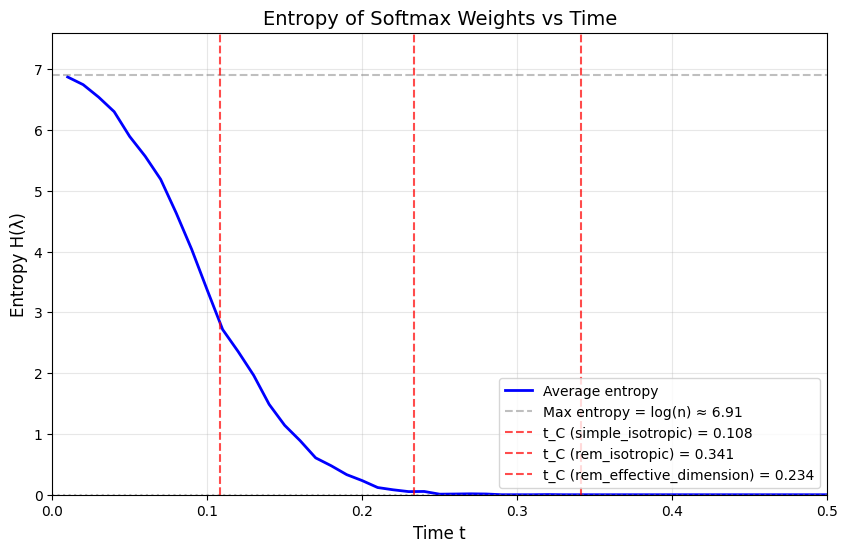

In [22]:
data = load_cifar10_data_numpy(1000)
plot_entropy_vs_time(data, collapse_times=collapse_times)

## Marginal Velocity Field and Position Field

We investigate the relationship between the marginal velocity field and the position field by evaluating their correlation. Specifically, for small $t$, we expect the marginal velocity field to be anti-correlated with the position field. The marginal velocity field is defined as:
$$
u_t(X_t) = \frac{\mathbb{E}[X_1 \mid X_t] - X_t}{1-t}.
$$
If the data is centered and $t$ is close to zero, we have:
$$
u_t(X_t) \approx \frac{0 - X_t}{1-t} \approx -X_t.
$$

To quantify this, we compute the **cosine similarity** between the marginal velocity and the current position $x_t$:

In [23]:
def compute_marginal_velocity(x_t: np.ndarray, data: np.ndarray, t: float) -> np.ndarray:
    """
    Compute the marginal velocity field u_t(x).
    
    u_t(x) = sum_i lambda_i(x, t) * (x^(i) - x) / (1 - t)
    
    Parameters
    ----------
    x_t : np.ndarray
        Current position, shape (d,)
    data : np.ndarray
        Training data, shape (n, d)
    t : float
        Time in [0, 1)
        
    Returns
    -------
    np.ndarray
        Velocity vector, shape (d,)
    """
    if t >= 1.0:
        raise ValueError("t must be < 1")
    
    # Compute weights
    weights = compute_lambda_weights(x_t, data, t)  # (n,)
    
    # Compute weighted sum of (x^(i) - x)
    directions = data - x_t[np.newaxis, :]  # (n, d)
    weighted_sum = np.sum(weights[:, np.newaxis] * directions, axis=0)  # (d,)
    
    return weighted_sum / (1 - t)


def compute_cosine_similarity(u: np.ndarray, v: np.ndarray) -> float:
    """
    Compute cosine similarity between two vectors.
    
    Parameters
    ----------
    u, v : np.ndarray
        Input vectors
        
    Returns
    -------
    float
        Cosine similarity in [-1, 1]
    """
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    if norm_u < 1e-10 or norm_v < 1e-10:
        return 0.0
    return np.dot(u, v) / (norm_u * norm_v)


def compute_velocity_correlation_vs_time(
    data: np.ndarray, 
    n_samples: int,
    t_values: np.ndarray,
    seed: int | None = None
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute correlation between marginal velocity u_t(x_t) and position x_t.
    
    For each t, draw samples x_t = (1-t)*x_0 + t*x_1 and compute:
    - Marginal velocity: u_t(x_t)
    - Position: x_t
    
    The correlation should be close to -1 for small t (velocity points opposite
    to position, pushing noise toward data), then becomes complicated around
    t ≈ 0.1 (the collapse transition regime), illustrating the difficulty of
    approximating the true marginal velocity field.
    
    Parameters
    ----------
    data : np.ndarray
        Training data, shape (n, d)
    n_samples : int
        Number of samples to average over
    t_values : np.ndarray
        Time values to evaluate
    seed : int, optional
        Random seed for reproducibility
        
    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        (mean_correlations, std_correlations) each of shape (len(t_values),)
    """
    if seed is not None:
        np.random.seed(seed)
    
    n, d = data.shape
    mean_correlations = np.zeros(len(t_values))
    std_correlations = np.zeros(len(t_values))
    
    for i, t in enumerate(t_values):
        if t >= 1.0:
            mean_correlations[i] = 0.0
            std_correlations[i] = 0.0
            continue
            
        correlations = []
        
        for _ in range(n_samples):
            # Sample x_0 from N(0, I_d)
            x_0 = np.random.randn(d)
            
            # Sample x_1 uniformly from data
            idx = np.random.randint(n)
            x_1 = data[idx]
            
            # Compute x_t
            x_t = (1 - t) * x_0 + t * x_1
            
            # Compute marginal velocity
            u_marginal = compute_marginal_velocity(x_t, data, t)
            
            # Compute cosine similarity between velocity and position
            corr = compute_cosine_similarity(u_marginal, x_t)
            correlations.append(corr)
        
        mean_correlations[i] = np.mean(correlations)
        std_correlations[i] = np.std(correlations)
    
    return mean_correlations, std_correlations

In [24]:
def plot_correlation_vs_time(
    data: np.ndarray, 
    n_samples: int = 100,
    t_values: np.ndarray | None = None,
    t_max: float = 0.5,
    seed: int | None = 42,
    collapse_times: dict[str, float] | None = None,
    show_std: bool = True,
    figsize: tuple[float, float] = (10, 6),
) -> None:
    """
    Plot correlation between marginal velocity field and position x vs time.
    
    The correlation (cosine similarity) between u_t(x_t) and x_t should be:
    - Close to -1 for small t (velocity points opposite to position, pushing
      noise toward the data distribution)
    - Becomes complicated around t ≈ 0.1 (the collapse transition regime)
    
    This illustrates why it's difficult to approximate the marginal velocity
    field around the collapse time - the function behavior changes rapidly.
    
    Parameters
    ----------
    data : np.ndarray
        Training data, shape (n, d)
    n_samples : int
        Number of samples to average over at each time
    t_values : np.ndarray, optional
        Time values to evaluate. If None, uses linspace(0.01, t_max, 50)
    t_max : float
        Maximum time value (default 0.5)
    seed : int, optional
        Random seed for reproducibility
    collapse_times : dict[str, float], optional
        Dictionary of collapse times
    show_std : bool
        Whether to show standard deviation as shaded region
    figsize : tuple
        Figure size if creating new figure
    """
    if t_values is None:
        t_values = np.linspace(0.01, t_max, 50)
    
    # Compute correlations
    mean_corr, std_corr = compute_velocity_correlation_vs_time(
        data, n_samples, t_values, seed=seed
    )
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot correlation with optional std band
    ax.plot(t_values, mean_corr, 'b-', linewidth=2, label='Mean cosine similarity')
    
    if show_std:
        ax.fill_between(t_values, mean_corr - std_corr, mean_corr + std_corr,
                        alpha=0.3, color='blue', label='±1 std')
    
    # Reference lines
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax.axhline(y=-1.0, color='gray', linestyle='--', alpha=0.5, label='Anti-correlation (-1)')
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Correlation (+1)')
    
    # Show collapse times
    if collapse_times is not None:
        for method, t_c in collapse_times.items():
            if t_c <= t_max:
                ax.axvline(x=t_c, color='red', linestyle='--', alpha=0.7,
                          label=f't_C ({method}) = {t_c:.3f}')
    
    ax.set_xlabel('Time t', fontsize=12)
    ax.set_ylabel('Cosine similarity (u_t, x_t)', fontsize=12)
    ax.set_title('Correlation: Marginal Velocity Field vs Position', fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, t_max])
    ax.set_ylim([-1.1, 1.1])

    plt.savefig("output/velocity_correlation_vs_time.png", bbox_inches='tight')
    plt.show()

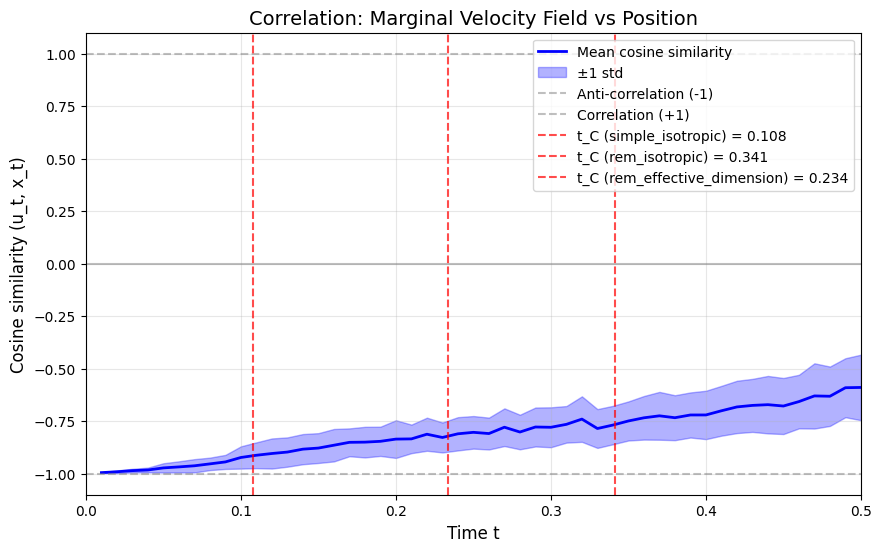

In [25]:
data = load_cifar10_data_numpy(1000)
plot_correlation_vs_time(data, collapse_times=collapse_times)
